# Markov Chain Monte Carlo

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 13 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

Modern astronomical analyses frequently encounter probability distributions too complex for analytical treatment. Whether inferring stellar parameters from spectra, constraining dark matter halo properties from lensing data, or estimating galaxy redshifts from photometry, we face high-dimensional parameter spaces with intricate likelihood surfaces. While the sampling methods explored in Chapter 12 provide powerful tools for many problems, they struggle when distributions have complex shapes, multiple modes, or exist in high dimensions. This tutorial introduces Markov Chain Monte Carlo (MCMC) methods, which overcome these limitations through an elegant approach: constructing random walks that naturally spend more time in high-probability regions.

The key insight behind MCMC is deceptively simple. Rather than attempting to sample directly from a complex distribution, we build a Markov chain—a sequence of samples where each depends only on the previous one—designed to have our target distribution as its equilibrium state. By simulating this chain long enough, we obtain samples that approximate our desired distribution, regardless of its complexity. This approach has revolutionized Bayesian inference in astronomy, enabling rigorous uncertainty quantification for problems that were previously intractable.

MCMC methods excel precisely where traditional sampling approaches fail. In high-dimensional spaces, rejection sampling becomes hopelessly inefficient as the acceptance rate plummets exponentially with dimension. Importance sampling struggles to find good proposal distributions when the target has complex structure. MCMC sidesteps these issues by exploring the parameter space through local moves, naturally adapting to the shape of the distribution. The price we pay is correlation between successive samples—our random walk generates a dependent sequence rather than independent draws. Understanding and managing this correlation is key to effective MCMC implementation.

This tutorial explores two fundamental MCMC algorithms through carefully chosen examples that illustrate core concepts. We begin with the Metropolis-Hastings algorithm, demonstrating how it samples from arbitrary distributions using only the ability to evaluate probability ratios. We then examine Gibbs sampling, which achieves efficient sampling by exploiting conditional distribution structure. Through these examples, we'll develop practical skills in implementing MCMC, diagnosing convergence, and interpreting results—essential tools for modern astronomical data analysis.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Probability Theory**: Understanding of probability distributions, Bayes' theorem, and conditional probability
- **Bayesian Statistics**: Prior distributions, likelihood functions, and posterior inference
- **Sampling Methods**: Basic concepts from Chapter 12, including rejection and importance sampling
- **Python Programming**: Experience with NumPy, matplotlib, and basic scientific computing
- **Linear Algebra**: Comfort with vectors, matrices, and multivariate distributions

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Metropolis-Hastings Algorithm**: Implement this foundational MCMC technique and understand how proposal distributions affect sampling efficiency
- **Gibbs Sampling**: Master this specialized approach for problems with tractable conditional distributions
- **Convergence Diagnostics**: Apply the Geweke and Gelman-Rubin tests to assess whether chains have reached their stationary distribution
- **Autocorrelation Analysis**: Quantify the correlation between samples and calculate effective sample sizes
- **Practical MCMC**: Recognize common problems like poor mixing and slow convergence, and apply solutions like burn-in and thinning

### Astronomical Context

While MCMC has broad applications across astronomy, this tutorial focuses on fundamental concepts through accessible examples. We begin with parameter estimation for a simple statistical model, then explore how correlation structure affects sampling efficiency. These foundational examples provide the intuition needed to tackle more complex astronomical inference problems, from fitting spectral models to constraining cosmological parameters.

We begin by importing the necessary libraries and configuring our computational environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

%matplotlib inline

## The Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm provides a powerful framework for sampling from complex probability distributions when direct sampling isn't feasible. Its elegance lies in requiring only the ability to evaluate probability ratios, eliminating the need for normalization constants that plague many inference problems in astronomy.

### The Physical Intuition

Before diving into mathematical details, let's build intuition through an analogy. Imagine an astronomer exploring an unfamiliar mountain range at night, searching for the highest peaks where observatories might be built. With limited visibility and no map, a reasonable strategy might be:

1. Evaluate the elevation at your current position
2. Choose a random direction and consider taking a step
3. If the new position is higher, definitely move there
4. If the new position is lower, sometimes move there anyway (to avoid getting stuck on minor peaks)
5. Record your path to build a map of the terrain

This exploration strategy mirrors how the Metropolis-Hastings algorithm works. The "elevation" corresponds to probability density, and our goal is to map the probability landscape by spending more time in high-probability regions. The key insight is that even a random walk, when properly biased toward higher probabilities, will eventually reveal the shape of the distribution.

### Mathematical Foundation

The theoretical foundations of MCMC rest on two key principles that guarantee convergence to our target distribution:

**Detailed Balance**

For a Markov chain to converge to a specific distribution, it must satisfy detailed balance. This condition ensures that transitions between states maintain the desired equilibrium distribution. Mathematically, detailed balance requires:

$$p(\mathbf{x}) T(\mathbf{x}, \mathbf{x}') = p(\mathbf{x}') T(\mathbf{x}', \mathbf{x})$$

where $p$ represents the target distribution and $T$ denotes the transition probability from state $\mathbf{x}$ to state $\mathbf{x}'$. This equation states that the probability flow from $\mathbf{x}$ to $\mathbf{x}'$ equals the flow in the reverse direction when the system is in equilibrium.

**Ergodicity**

The chain must be ergodic, meaning every possible state can be reached from any other state given sufficient steps. This property ensures the chain will fully explore the parameter space rather than getting trapped in disconnected regions. Ergodicity requires the chain to be both irreducible (all states communicate) and aperiodic (no cyclical patterns that prevent convergence).

The remarkable strength of MCMC lies in its ability to sample from essentially any posterior distribution, regardless of complexity or dimensionality. The Metropolis algorithm, through its carefully designed acceptance probability, automatically ensures detailed balance with respect to our target distribution. When combined with ergodicity—typically guaranteed by using continuous proposal distributions—we have a complete foundation for sampling from our target.

### The Metropolis Algorithm: Step by Step

The Metropolis algorithm implements a specific form of transition probability that guarantees detailed balance. For a symmetric proposal distribution $q(\mathbf{x}'|\mathbf{x}) = q(\mathbf{x}|\mathbf{x}')$, the algorithm becomes particularly elegant.

The transition probability takes the form $T(\mathbf{x}, \mathbf{x}') = q(\mathbf{x}'|\mathbf{x})A(\mathbf{x}, \mathbf{x}')$, where $A$ is the acceptance probability:

$$A(\mathbf{x}, \mathbf{x}') = \min\left(1, \frac{p(\mathbf{x}'|\mathcal{D})}{p(\mathbf{x}|\mathcal{D})}\right)$$

This acceptance rule has a beautiful interpretation: we always accept moves to higher probability regions, but only sometimes accept moves to lower probability regions. The probability of accepting a downward move depends on how much lower the new state's probability is.

The power of this approach lies in its dependence only on probability ratios. Since the posterior is proportional to the likelihood times the prior, $p(\mathbf{x}|\mathcal{D}) \propto p(\mathcal{D}|\mathbf{x})p(\mathbf{x})$, we can compute this ratio without the normalization constant:

$$\frac{p(\mathbf{x}'|\mathcal{D})}{p(\mathbf{x}|\mathcal{D})} = \frac{p(\mathcal{D}|\mathbf{x}')p(\mathbf{x}')}{p(\mathcal{D}|\mathbf{x})p(\mathbf{x})}$$

The implementation follows these steps:

1. **Initialize**: Choose a starting point $\mathbf{x}^{(0)}$ in parameter space

2. **Iterate**: For $t = 1, 2, \ldots, T$:
   - **Propose**: Generate $\mathbf{x}' \sim q(\mathbf{x}'|\mathbf{x}^{(t-1)})$
   - **Accept/Reject**: With probability $A(\mathbf{x}^{(t-1)}, \mathbf{x}')$, set $\mathbf{x}^{(t)} = \mathbf{x}'$; otherwise $\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)}$

3. **Return**: The sequence $\{\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(T)}\}$

## Estimating the Sample Mean

To build practical understanding, let's apply the Metropolis algorithm to a concrete problem: estimating the mean of a population from noisy observations. While this problem has analytical solutions, it provides an ideal testbed for understanding MCMC behavior before tackling more complex astronomical inference problems.

### The Statistical Model

Consider a scenario where we observe $n$ measurements $\{x_i\}$ drawn from a normal distribution with unknown mean $\mu$ and known standard deviation $\sigma = 1$. This setup mimics many astronomical situations—measuring the mean radial velocity of a star cluster, the average metallicity of a stellar population, or the systematic offset in photometric measurements.

In Bayesian terms, we seek the posterior distribution:

$$p(\mu | \{x_i\}) \propto p(\{x_i\} | \mu) \times p(\mu)$$

For independent observations from a normal distribution, the likelihood is:

$$p(\{x_i\} | \mu) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x_i - \mu)^2}{2}\right)$$

We'll use a Cauchy prior for $\mu$, which has heavier tails than a normal distribution:

$$p(\mu) = \frac{1}{\pi\gamma} \frac{1}{1 + \left(\frac{\mu-\mu_0}{\gamma}\right)^2}$$

where $\mu_0 = 0$ is the location parameter and $\gamma = 3$ is the scale parameter. The Cauchy prior is more robust to outliers than a normal prior, making it useful when we have limited prior knowledge about the parameter range.

Working in log space for numerical stability:

$$\log p(\mu | \{x_i\}) = \sum_{i=1}^n \log p(x_i | \mu) + \log p(\mu) + \text{const}$$

In [2]:
# Generate a sample from a normal distribution with a fixed variance of one
n = 1000
loc_true = 1
x_sample = np.random.normal(loc=loc_true, scale=1, size=n)

# Let's examine the first few values and basic statistics
print(f"First 10 observations: {x_sample[:10]}")
print(f"Sample mean: {np.mean(x_sample):.4f}")
print(f"Sample standard deviation: {np.std(x_sample):.4f}")
print(f"True mean (to be estimated): {loc_true}")

First 10 observations: [1.49671415 0.8617357  1.64768854 2.52302986 0.76584663 0.76586304
 2.57921282 1.76743473 0.53052561 1.54256004]
Sample mean: 1.0193
Sample standard deviation: 0.9787
True mean (to be estimated): 1


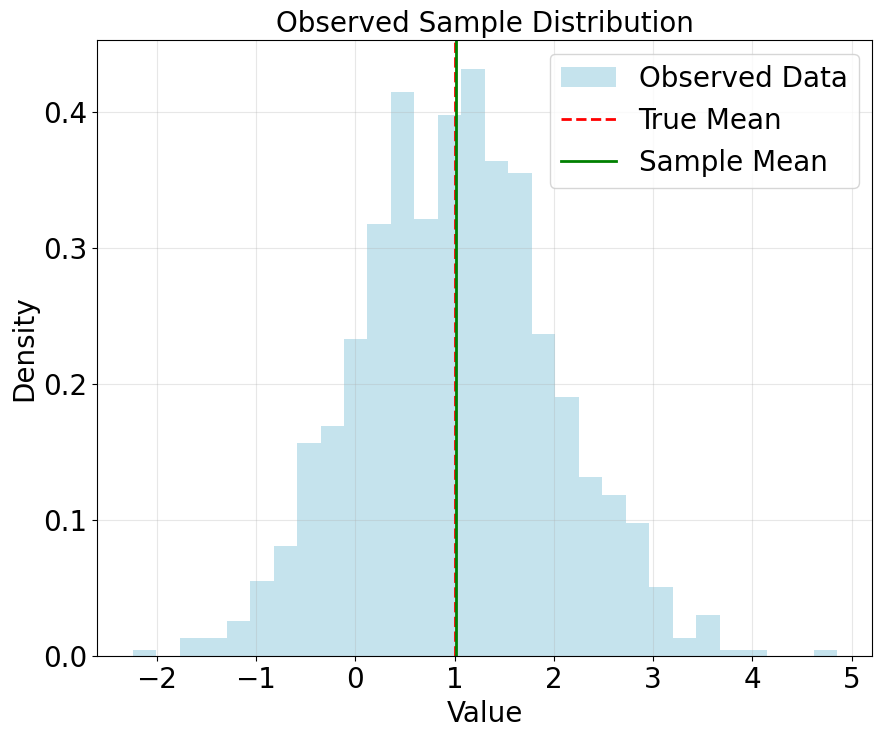

In [3]:
# Visualize the sample
plt.figure(figsize=(10, 8))
plt.hist(x_sample, bins=30, density=True, alpha=0.7, color='lightblue', label='Observed Data')
plt.axvline(x=loc_true, color='r', linestyle='--', linewidth=2, label='True Mean')
plt.axvline(x=np.mean(x_sample), color='g', linestyle='-', linewidth=2, label='Sample Mean')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Observed Sample Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Implementing the Log-Posterior Function

The first step in our MCMC implementation is to define the log-posterior function. Working in log space provides numerical stability, especially when dealing with products of small probabilities that arise from many observations.

Our log-posterior combines:
1. The log-likelihood, which measures how well a proposed mean $\mu$ explains our observed data
2. The log-prior, which encodes our prior beliefs about plausible values of $\mu$

The Cauchy prior's heavy tails make it particularly useful in astronomical applications where outliers are common or when we want to be conservative about excluding extreme parameter values.


In [4]:
def log_posterior(mu, x_sample):
    """
    Calculate the log posterior probability for a given mean value.
    
    Parameters:
    -----------
    mu : float
        The proposed mean value
    x_sample : array
        The observed data sample
        
    Returns:
    --------
    log_post : float
        The log posterior probability
    """
    # Log likelihood (normal distribution)
    log_likelihood = np.sum(stats.norm.logpdf(x_sample, loc=mu, scale=1))
    
    # Log prior (Cauchy distribution)
    log_prior = stats.cauchy.logpdf(mu, loc=0, scale=3)
    
    # Log posterior (up to a constant)
    return log_likelihood + log_prior

### The Proposal Mechanism

In the Metropolis algorithm, we need a way to propose new parameter values to explore the space. The proposal distribution is crucial for efficient sampling—it determines how we move through parameter space and directly impacts the algorithm's performance.

For this problem, we'll use a normal distribution centered at the current value of $\mu$, with standard deviation $\nu$ that controls the "step size":

$$q(\mu' | \mu) = \mathcal{N}(\mu', \mu, \nu^2)$$

This choice satisfies the symmetry requirement $q(\mu' | \mu) = q(\mu | \mu')$, allowing us to use the simpler Metropolis algorithm rather than the full Metropolis-Hastings. The parameter $\nu$ represents a critical tuning choice:

- **Small $\nu$**: Conservative steps that rarely venture far from the current position
- **Large $\nu$**: Aggressive steps that explore broadly but may frequently land in low-probability regions

Finding the right balance is key to efficient sampling. Too small and the chain explores slowly; too large and most proposals get rejected.


In [5]:
def proposal(mu, nu):
    """
    Generate a proposal for the next state in the Metropolis algorithm.
    
    Parameters:
    -----------
    mu : float
        Current value of the mean
    nu : float
        Standard deviation of the proposal distribution
        
    Returns:
    --------
    mu_proposed : float
        Proposed new value for the mean
    """
    return stats.norm.rvs(loc=mu, scale=nu, size=1).item()

### Implementing the Metropolis Algorithm

Now we'll implement the Metropolis algorithm, which forms the core of our MCMC sampler. Since our proposal distribution is symmetric, we can use the simpler Metropolis variant rather than the full Metropolis-Hastings algorithm.

Our implementation will:
1. Initialize the chain at a starting value
2. Generate proposals using our symmetric normal distribution
3. Accept or reject each proposal based on the posterior ratio
4. Track the acceptance rate as a diagnostic metric

The acceptance rate provides crucial feedback about our choice of proposal width $\nu$. Very high acceptance rates (>90%) suggest we're taking steps that are too small, while very low rates (<20%) indicate overly ambitious proposals. The sweet spot typically lies between 20-50% acceptance for one-dimensional problems.

In [6]:
def metropolis_hastings(mu_init, nu, n_iterations):
    """
    Run the Metropolis-Hastings algorithm to sample from the posterior.
    
    Parameters:
    -----------
    mu_init : float
        Initial value for the mean
    nu : float
        Standard deviation of the proposal distribution
    n_iterations : int
        Number of iterations to run
        
    Returns:
    --------
    chain : list
        The Markov chain of samples
    accept_ratio : float
        Proportion of proposed values that were accepted
    """
    # Initialize the chain with the starting value
    chain = [mu_init]
    mu = mu_init
    accept_count = 0
    
    # Run the chain for n iterations
    for i in tqdm(range(n_iterations)):
        # Step 1: Propose a new value
        mu_star = proposal(mu, nu)
        
        # Step 2: Calculate acceptance ratio (in log space for stability)
        log_ratio = log_posterior(mu_star, x_sample) - log_posterior(mu, x_sample)
        alpha = min(1, np.exp(log_ratio))
        
        # Step 3: Accept or reject
        u = np.random.uniform()
        if u < alpha:
            mu = mu_star
            accept_count += 1
        
        # Step 4: Add the current state to the chain
        chain.append(mu)
    
    # Calculate the acceptance ratio
    accept_ratio = accept_count / n_iterations * 100
    
    return chain, accept_ratio

Let's run our algorithm with three different proposal widths ($\nu$) to see how this parameter affects sampling performance. The proposal width controls how "adventurous" our exploration is:

- **Small $\nu$ (0.01)**: Takes tiny steps, resulting in high acceptance but slow exploration
- **Medium $\nu$ (0.1)**: Balances step size and acceptance for efficient exploration  
- **Large $\nu$ (0.5)**: Takes large leaps, exploring quickly but with many rejections

For each case, we'll run 10,000 iterations starting from $\mu_{\text{init}} = 0$.

In [7]:
# Define parameters for our experiment
nu_values = [0.01, 0.1, 0.5]
mu_init = 0
n_iterations = 10000
results = {}

# Run the Metropolis-Hastings algorithm for each proposal width
for nu in nu_values:
    print(f"\nRunning Metropolis-Hastings with proposal width ν = {nu}")
    chain, accept_ratio = metropolis_hastings(mu_init, nu, n_iterations)
    results[nu] = (chain, accept_ratio)
    print(f"Acceptance ratio: {accept_ratio:.1f}%")


Running Metropolis-Hastings with proposal width ν = 0.01


100%|██████████| 10000/10000 [00:01<00:00, 6679.91it/s]


Acceptance ratio: 90.0%

Running Metropolis-Hastings with proposal width ν = 0.1


100%|██████████| 10000/10000 [00:01<00:00, 6774.79it/s]


Acceptance ratio: 35.9%

Running Metropolis-Hastings with proposal width ν = 0.5


100%|██████████| 10000/10000 [00:01<00:00, 6412.25it/s]

Acceptance ratio: 8.2%


### Visualizing the Chains

Let's visualize the first 1000 samples from each chain to understand how the proposal width ($\nu$) affects the sampling behavior. The trace plots reveal how quickly each chain converges to the stationary distribution and how efficiently it explores the parameter space.


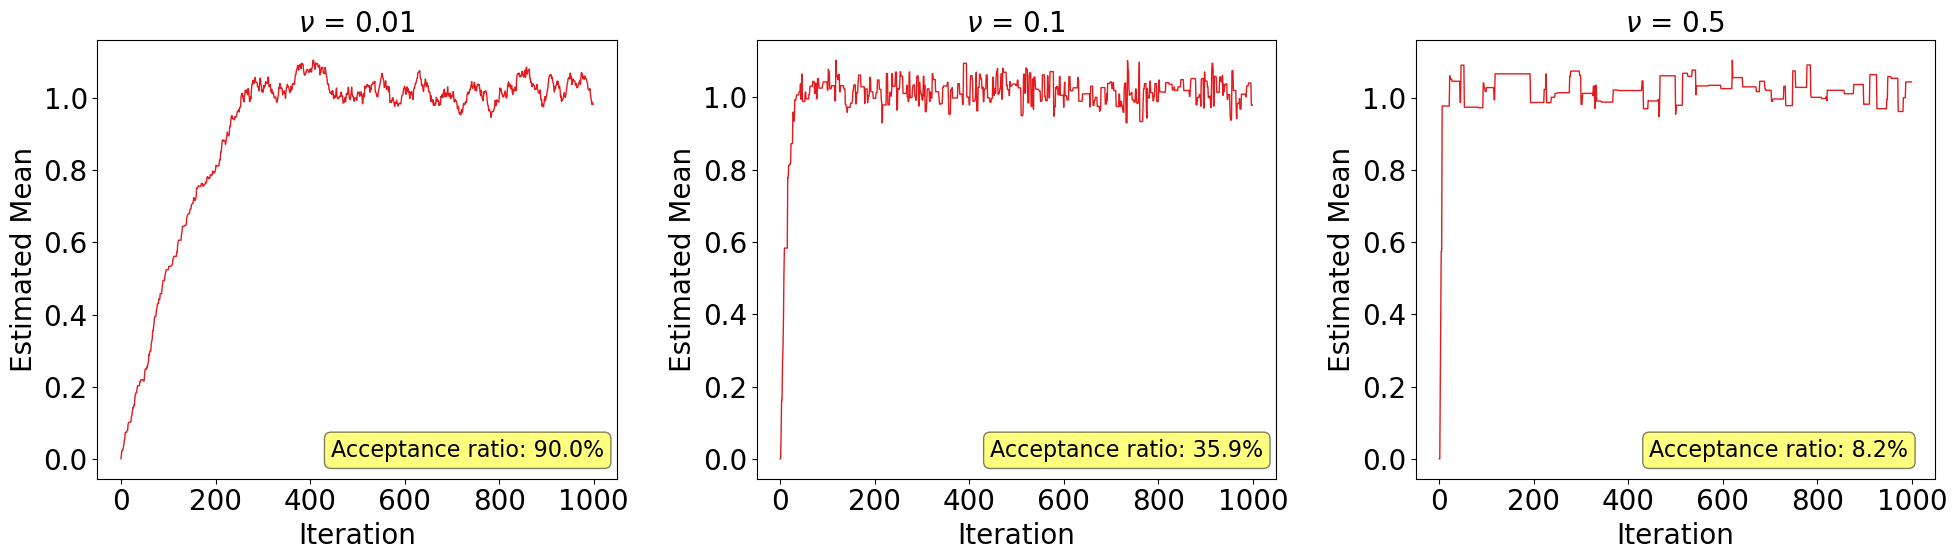

In [10]:
# Create a figure with three subplots for our different values of nu
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# For each value of nu, plot the first 1000 samples of the chain
for index, nu in enumerate(nu_values):
    ax = axes[index]
    chain, accept_ratio = results[nu]
    
    # Plot only the first 1000 samples to see the initial behavior
    ax.plot(chain[:1000], linewidth=1) 
    
    # Add labels and title
    ax.set_title(f"$\\nu$ = {nu}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Estimated Mean")
    
    # Add the acceptance ratio as text in the plot
    ax.text(0.45, 0.05, f"Acceptance ratio: {accept_ratio:.1f}%", 
            transform=ax.transAxes, fontsize=16,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

plt.tight_layout()
plt.show()

### Autocorrelation and Effective Sample Size

The trace plots reveal dramatically different behaviors across our three proposal widths:

- **Small $\nu = 0.01$**: The chain moves in tiny increments, creating a smooth but slowly varying trace. The very high acceptance rate reflects that almost every proposal is accepted, but the chain takes thousands of iterations to fully explore the posterior distribution. This "random walk" behavior is inefficient—consecutive samples are highly correlated, providing little new information.

- **Medium $\nu = 0.1$**: The chain shows healthy mixing with moderate jumps between states. The moderate acceptance rate indicates a good balance between exploration and acceptance. The chain quickly converges to the stationary distribution and efficiently explores the full range of plausible values.

- **Large $\nu = 0.5$**: The chain exhibits a "sticky" behavior, remaining at the same value for many iterations before occasionally jumping to a new location. The low acceptance rate means most proposals are rejected, leading to redundant samples and inefficient exploration.

To quantify these qualitative observations, we need to examine the autocorrelation structure of our chains. In MCMC, successive samples are inherently correlated—each new state depends on the previous one. Understanding this correlation is crucial for assessing how much independent information our chains provide.

For a sequence of samples $\{X_0, X_1, X_2, ...\}$, the autocorrelation at lag $k$ measures how correlated samples are when separated by $k$ steps:

$$ R(k) = \frac{E[(X_t - \mu)(X_{t+k} - \mu)]}{\sigma^2} $$

where $\mu$ is the mean and $\sigma^2$ is the variance of the stationary distribution. In practice, we estimate this from our finite chain.

The autocorrelation function provides crucial insights:
- Independent samples would have $R(k) = 0$ for all $k > 0$
- MCMC samples typically show decaying autocorrelation as lag increases
- The decay rate determines how many samples we need for reliable estimates

The effective sample size (ESS) quantifies how many truly independent samples our correlated chain represents:

$$ \text{ESS} = \frac{N}{1 + 2\sum_{k=1}^{\infty}R(k)} $$

A chain with high autocorrelation might contain 10,000 samples but have an ESS of only 100, meaning it provides no more information than 100 independent draws from the posterior.

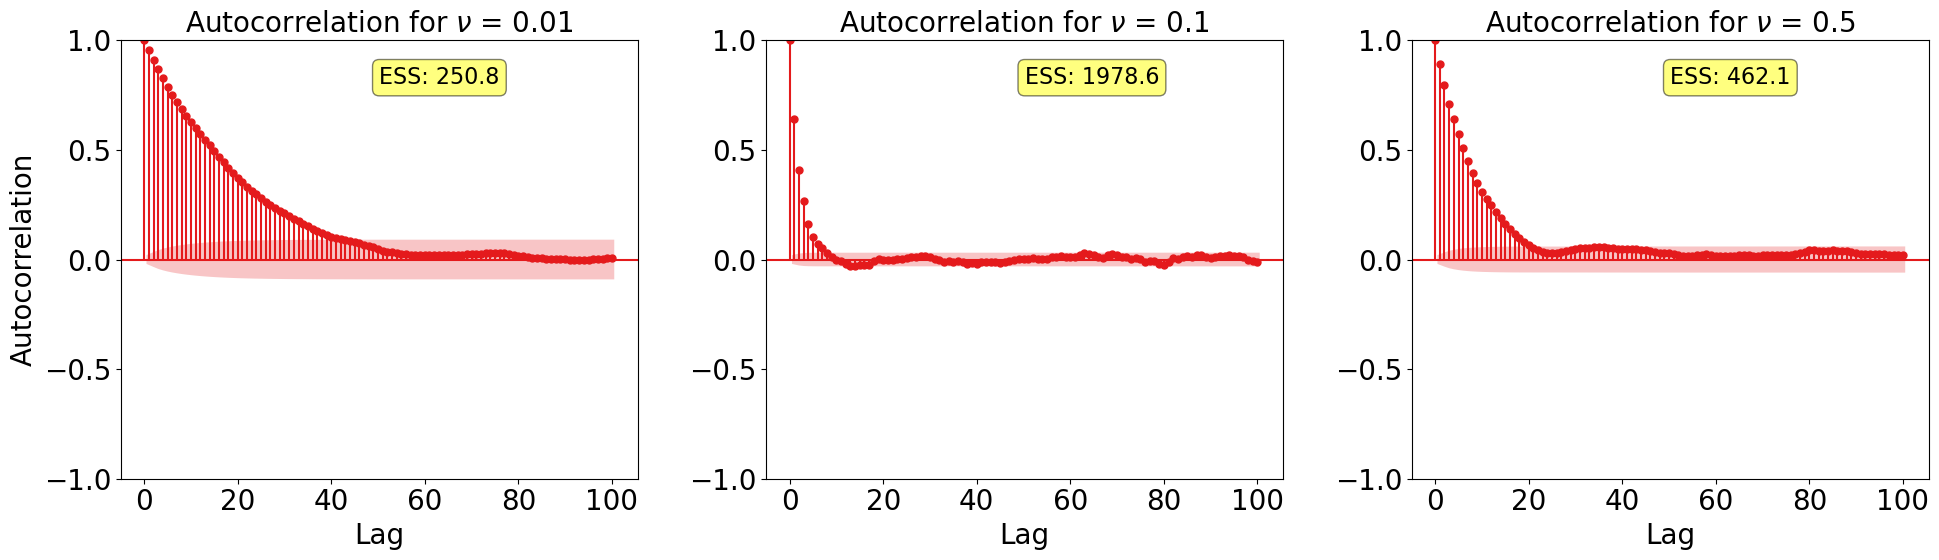

In [11]:
def calculate_ess(samples):
    """
    Calculate the Effective Sample Size for a Markov chain.
    
    Parameters:
    -----------
    samples : array
        The Markov chain samples
        
    Returns:
    --------
    ess : float
        The effective sample size
    """
    # Calculate autocorrelation up to lag 100
    # Using fft=True for more efficient computation
    N = len(samples)
    autocorr_values = sm.tsa.acf(samples, nlags=100, fft=True)
    
    # Calculate ESS using the formula
    # ESS = N / (1 + 2*sum(autocorrelations))
    return N / (1 + 2 * sum(autocorr_values[1:]))

# Create a figure for autocorrelation plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for index, nu in enumerate(nu_values):
    ax = axes[index]
    chain, _ = results[nu]
    
    # Discard the first 500 samples as burn-in
    chain = chain[500:]
    
    # Plot the autocorrelation function
    sm.graphics.tsa.plot_acf(chain, lags=100, ax=ax)
    ax.set_title(f"Autocorrelation for $\\nu$ = {nu}")
    ax.set_xlabel("Lag")
    
    if index == 0:
        ax.set_ylabel("Autocorrelation")
    
    # Calculate and display the effective sample size
    ess = calculate_ess(chain)
    ax.text(0.5, 0.9, f"ESS: {ess:.1f}", transform=ax.transAxes, fontsize=16,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

plt.tight_layout()
plt.show()

The autocorrelation plots reveal striking differences in sampling efficiency:

**Small Proposal Width ($\nu = 0.01$)**
- Autocorrelation decays extremely slowly, remaining significant even at lag 100
- The slow decay indicates that samples separated by many iterations still contain redundant information
- Despite generating thousands of samples, the effective sample size is drastically reduced
- This confirms our visual observation: the chain moves too cautiously through parameter space

**Medium Proposal Width ($\nu = 0.1$)**  
- Autocorrelation drops rapidly, approaching zero within 20-30 lags
- This quick decay indicates that samples become effectively independent after relatively few iterations
- The higher ESS confirms this is our most efficient sampler
- The chain achieves a good balance between acceptance and exploration

**Large Proposal Width ($\nu = 0.5$)**
- Shows an interesting pattern with moderate initial decay followed by persistent low-level correlation
- The "sticky" behavior we observed visually manifests as extended autocorrelation
- Many rejected proposals mean the chain often stays in place, reducing the effective sample size
- While better than the overly cautious chain, it's still less efficient than the moderate proposal width

These results illustrate a fundamental trade-off in MCMC: proposal width must be tuned to balance acceptance rate with exploration efficiency. The optimal choice typically yields moderate acceptance rates and rapid autocorrelation decay.

### Convergence Diagnostics

Before using our MCMC samples for inference, we must verify that the chains have converged to their stationary distribution. Visual inspection provides some intuition, but rigorous statistical tests offer more reliable evidence.

#### The Geweke Test

The Geweke test compares the means of different segments of a single MCMC chain. If the chain has converged to its stationary distribution, different portions should exhibit similar statistical properties.

The test works by:
1. Comparing the mean of the first portion (typically 10% of the chain) with the mean of the last portion (typically 50%)
2. Computing a Z-score that accounts for the autocorrelation within each segment
3. Testing if this Z-score is consistent with a standard normal distribution

If the Z-score has magnitude less than 2 (roughly corresponding to a 95% confidence interval), we have evidence that the chain has likely converged.

The test specifically accounts for autocorrelation by estimating the spectral density at frequency zero for each segment. This adjustment is crucial because correlated samples have higher variance than independent samples, affecting the reliability of mean estimates.

In [12]:
def geweke_test(chain, first=0.1, last=0.5, max_lag=20):
    """
    Perform the Geweke test for MCMC convergence.
    
    Parameters:
    -----------
    chain : array
        The Markov chain samples
    first : float
        Fraction of chain to use for the first segment (default: 0.1)
    last : float
        Fraction of chain to use for the last segment (default: 0.5)
    max_lag : int
        Maximum lag for autocorrelation estimation
        
    Returns:
    --------
    z_score : float
        The Geweke Z-score
    """
    n = len(chain)
    
    # Define the segments
    n_a = int(first * n)
    n_b = int(last * n)
    
    segment_a = chain[:n_a]
    segment_b = chain[-n_b:]
    
    # Calculate means
    mean_a = np.mean(segment_a)
    mean_b = np.mean(segment_b)
    
    # Estimate spectral densities at frequency zero (accounting for autocorrelation)
    def spectral_density(x):
        acf_values = sm.tsa.acf(x, nlags=max_lag, fft=True)
        # Apply window function (1 - k/max_lag) to reduce noise at higher lags
        window = 1 - np.arange(max_lag+1)/max_lag
        # Calculate spectral density
        var_x = np.var(x)
        s0 = var_x * (1 + 2 * np.sum(window[1:] * acf_values[1:]))
        return s0
    
    s_a = spectral_density(segment_a)
    s_b = spectral_density(segment_b)
    
    # Calculate Z-score
    z_score = (mean_a - mean_b) / np.sqrt(s_a/n_a + s_b/n_b)
    
    return z_score

# Test convergence for each chain
print("Geweke Convergence Test Results:")
print("-" * 40)
for nu in nu_values:
    chain, _ = results[nu]
    z = geweke_test(chain)
    print(f"ν = {nu}: Z-score = {z:.3f}")
    
    # Interpret the result
    if abs(z) < 2:
        print("  → Evidence suggests the chain has converged.")
    else:
        print("  → Evidence suggests the chain may not have converged.")
    print()


Geweke Convergence Test Results:
----------------------------------------
ν = 0.01: Z-score = -3.396
  → Evidence suggests the chain may not have converged.

ν = 0.1: Z-score = -1.247
  → Evidence suggests the chain has converged.

ν = 0.5: Z-score = -0.611
  → Evidence suggests the chain has converged.



#### Gelman-Rubin Convergence Diagnostic

While the Geweke test examines a single chain, a more robust approach involves running multiple chains from different starting points and comparing their behavior. If all chains converge to the same distribution, they should become statistically indistinguishable after an appropriate burn-in period.

The Gelman-Rubin diagnostic formalizes this intuition by comparing within-chain variance to between-chain variance. The idea is simple but powerful: if chains have converged, the variance between different chains should be similar to the variance within each chain.

For our parameter $\mu$, we calculate:

1. **Within-chain variance ($W$)**: The average of the variances of each individual chain
2. **Between-chain variance ($B$)**: The variance of the chain means, scaled by the chain length

The Gelman-Rubin statistic $\hat{R}$ is then:

$$\hat{R} = \sqrt{\frac{W + \frac{B-W}{n}}{W}}$$

When chains have converged:
- $B$ should approximately equal $W$
- Thus $\hat{R}$ should approach 1

Values of $\hat{R}$ below 1.1 (or 1.05 for stricter criteria) are generally considered evidence of convergence. Values substantially above 1 indicate that the chains have not yet converged to the same distribution.

In [13]:
def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin convergence diagnostic (R̂).
    
    Parameters:
    -----------
    chains : list of arrays
        List containing multiple chains (each an array of samples)
        
    Returns:
    --------
    R_hat : float
        The Gelman-Rubin statistic (values close to 1 indicate convergence)
    """
    # Number of chains and length of each chain
    m = len(chains)
    n = len(chains[0])
    
    # Calculate the mean of each chain
    chain_means = np.array([np.mean(chain) for chain in chains])
    
    # Calculate the variance of each chain
    chain_vars = np.array([np.var(chain, ddof=1) for chain in chains])
    
    # Calculate overall mean
    overall_mean = np.mean(chain_means)
    
    # Within-chain variance W (average of individual variances)
    W = np.mean(chain_vars)
    
    # Between-chain variance B
    B = n * np.var(chain_means, ddof=1)
    
    # Calculate R̂
    var_hat = W * (n - 1) / n + B / n
    R_hat = np.sqrt(var_hat / W)
    
    return R_hat

# Run multiple chains for the Gelman-Rubin test
n_chains = 4
n_iterations = 5000
chains = []

print("Running multiple chains for Gelman-Rubin diagnostic...")
print("-" * 40)
for i in range(n_chains):
    # Use different starting points for each chain
    mu_init = np.random.uniform(-3, 3)
    chain, _ = metropolis_hastings(mu_init, 0.1, n_iterations)
    # Discard burn-in
    chains.append(np.array(chain[500:]))
    print(f"Chain {i+1} complete, starting from μ = {mu_init:.2f}")

# Calculate and interpret the Gelman-Rubin statistic
r_hat = gelman_rubin(chains)
print(f"\nGelman-Rubin R̂ = {r_hat:.4f}")

if r_hat < 1.1:
    print("→ Chains have converged (R̂ < 1.1)")
elif r_hat < 1.05:
    print("→ Chains show excellent convergence (R̂ < 1.05)")
else:
    print("→ Chains may not have converged (R̂ ≥ 1.1)")


Running multiple chains for Gelman-Rubin diagnostic...
----------------------------------------


100%|██████████| 5000/5000 [00:00<00:00, 6270.62it/s]


Chain 1 complete, starting from μ = 2.34


100%|██████████| 5000/5000 [00:00<00:00, 6653.53it/s]


Chain 2 complete, starting from μ = -1.14


100%|██████████| 5000/5000 [00:00<00:00, 6771.81it/s]


Chain 3 complete, starting from μ = 2.11


100%|██████████| 5000/5000 [00:00<00:00, 6800.68it/s]

Chain 4 complete, starting from μ = -0.51

Gelman-Rubin R̂ = 1.0000
→ Chains have converged (R̂ < 1.1)


Our Gelman-Rubin statistic provides strong evidence of convergence. By starting multiple chains from different initial values and observing that they all converge to the same distribution, we gain confidence that our sampler has found the true posterior.

The combination of the Geweke test (examining single chains) and the Gelman-Rubin diagnostic (comparing multiple chains) gives us comprehensive evidence that our MCMC implementation with moderate proposal width ($\nu = 0.1$) reliably samples from the target posterior distribution.

### Posterior Analysis

With confidence in our convergence, we can now analyze the posterior distribution. We'll use the chain with moderate proposal width, applying standard post-processing steps:

1. **Burn-in removal**: Discard initial samples before the chain reached stationarity
2. **Thinning**: Keep every $k$-th sample to reduce autocorrelation and storage requirements
3. **Summary statistics**: Calculate posterior mean, standard deviation, and credible intervals

True mean: 1
Posterior mean: 1.019
Posterior standard deviation: 0.032
95% credible interval: [0.955, 1.078]


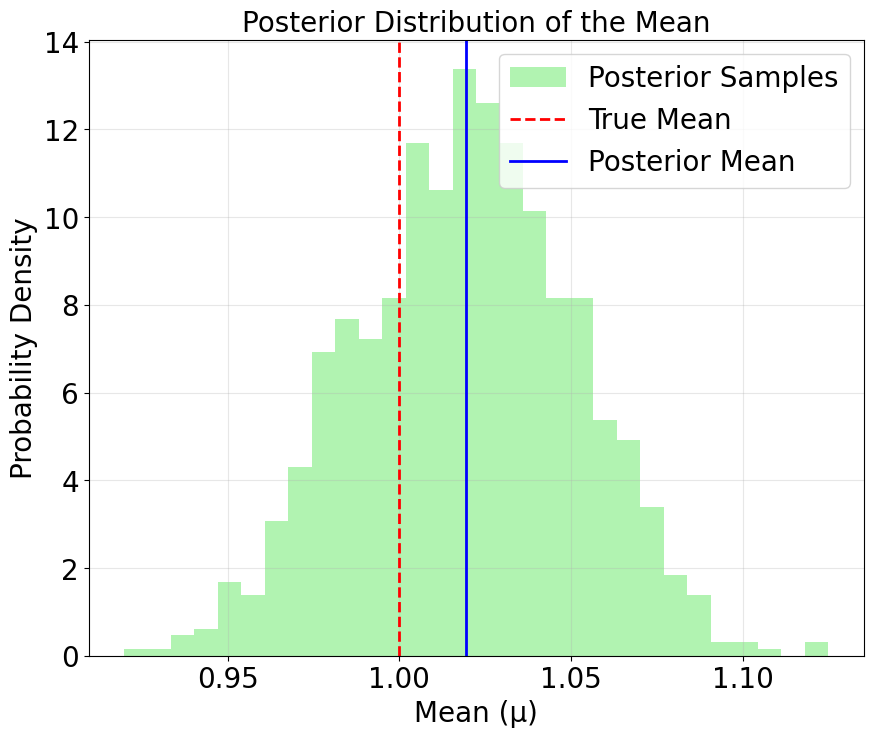

In [14]:
# Select the chain with moderate proposal width
chain = results[0.1][0]

# Apply burn-in: discard the first 500 samples
burn_in = 500
chain_post_burnin = chain[burn_in:]

# Apply thinning: keep every 10th sample
thinning = 10
thinned_chain = chain_post_burnin[::thinning]

# Create histogram of the posterior
plt.figure(figsize=(10, 8))
plt.hist(thinned_chain, bins=30, density=True, alpha=0.7, color='lightgreen', 
         label='Posterior Samples')
plt.axvline(x=loc_true, color='red', linestyle='--', linewidth=2, label='True Mean')
plt.axvline(x=np.mean(thinned_chain), color='blue', linewidth=2, label='Posterior Mean')

# Add labels and title
plt.xlabel('Mean (μ)')
plt.ylabel('Probability Density')
plt.title('Posterior Distribution of the Mean')
plt.legend()
plt.grid(True, alpha=0.3)

# Print summary statistics
print(f"True mean: {loc_true}")
print(f"Posterior mean: {np.mean(thinned_chain):.3f}")
print(f"Posterior standard deviation: {np.std(thinned_chain):.3f}")

# Calculate 95% credible interval
ci_low = np.percentile(thinned_chain, 2.5)
ci_high = np.percentile(thinned_chain, 97.5)
print(f"95% credible interval: [{ci_low:.3f}, {ci_high:.3f}]")

plt.show()

### Interpreting the Posterior Distribution

The posterior distribution reveals several key insights:

1. **Parameter Recovery**: The posterior distribution correctly captures the true mean within its high-probability region, validating our implementation.

2. **Uncertainty Quantification**: The width of the distribution reflects our uncertainty about $\mu$ given the data. With 1000 observations, this uncertainty is relatively small, but the Bayesian framework naturally provides this complete picture.

3. **Credible Intervals**: Unlike frequentist confidence intervals, the 95% credible interval has a direct probabilistic interpretation—given our data and prior, we believe there's a 95% probability that $\mu$ lies within this range.

4. **Prior Influence**: The Cauchy prior's heavy tails allow for extreme values, but with substantial data, the likelihood dominates and the posterior concentrates near the sample mean.

This simple example demonstrates the power of MCMC for Bayesian inference. Even when analytical solutions exist (as they do for this conjugate normal-Cauchy problem), MCMC provides a general approach that extends seamlessly to complex models where analytical solutions are impossible.


## Gibbs Sampling

While the Metropolis algorithm provides a general approach for MCMC sampling, there are situations where we can achieve more efficient sampling by leveraging knowledge about the structure of our target distribution. Gibbs sampling is one such specialized technique that excels when we can sample from the conditional distributions of our parameters.

### The Intuition Behind Gibbs Sampling

Imagine we're trying to characterize a complex multivariate distribution—perhaps the joint distribution of stellar temperature and luminosity given spectroscopic observations. The full joint distribution might be complicated, but the conditional distributions (temperature given luminosity, luminosity given temperature) might be much simpler.

Gibbs sampling exploits this structure by:

1. Updating one parameter at a time while holding others fixed
2. Sampling directly from the conditional distribution of each parameter
3. Cycling through all parameters systematically

This approach is particularly powerful when:
- The conditional distributions have known forms that are easy to sample from
- Parameters exhibit strong correlations that make joint proposals inefficient
- The problem naturally decomposes into conditional components

Unlike Metropolis-Hastings, Gibbs sampling always accepts its proposals because we're sampling directly from the correct conditional distributions. However, this doesn't guarantee efficient sampling—strongly correlated parameters can still lead to slow exploration of the joint distribution.

### Sampling from a Bivariate Gaussian Distribution

Let's illustrate Gibbs sampling with a concrete example: sampling from a bivariate Gaussian distribution. This example, while analytically tractable, provides crucial insights into how correlation affects sampling efficiency—a lesson that extends to more complex astronomical inference problems.

Consider sampling from a bivariate Gaussian with zero mean and correlation coefficient $\rho$:

$$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}\right)$$

To implement Gibbs sampling, we need the conditional distributions $p(x_1 | x_2)$ and $p(x_2 | x_1)$. For a bivariate Gaussian, these conditional distributions are also Gaussian, with forms that can be derived from the properties of multivariate normal distributions:

$$p(x_1 | x_2) = \mathcal{N}(\rho x_2, 1-\rho^2)$$
$$p(x_2 | x_1) = \mathcal{N}(\rho x_1, 1-\rho^2)$$

These expressions reveal important structure:
- The conditional mean depends linearly on the conditioning variable, scaled by the correlation $\rho$
- The conditional variance $1-\rho^2$ decreases as correlation increases
- When $\rho = 0$ (independence), we recover $\mathcal{N}(0, 1)$ for both conditionals

The Gibbs sampling algorithm alternates between:
1. Sample $x_1^{(t+1)} \sim \mathcal{N}(\rho x_2^{(t)}, 1-\rho^2)$
2. Sample $x_2^{(t+1)} \sim \mathcal{N}(\rho x_1^{(t+1)}, 1-\rho^2)$

In [15]:
def gibbs_sampler(n_samples, rho):
    """
    Perform Gibbs sampling for a bivariate Gaussian distribution.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to draw
    rho : float
        Correlation coefficient of the bivariate Gaussian
        
    Returns:
    --------
    samples : array
        Array of sampled points with shape (n_samples, 2)
    """
    # Initialize storage for samples
    samples = np.zeros((n_samples, 2))
    
    # Start from an arbitrary point
    x1 = 100  # Intentionally far from the true distribution's center
    x2 = 100  # to demonstrate convergence behavior
    
    # Run the Gibbs sampling algorithm
    for i in range(n_samples):
        # Sample x1 from its conditional distribution given x2
        # For bivariate Gaussian: p(x1|x2) = N(rho*x2, 1-rho^2)
        x1 = np.random.normal(loc=rho*x2, scale=np.sqrt(1-rho**2))
        
        # Sample x2 from its conditional distribution given x1
        # For bivariate Gaussian: p(x2|x1) = N(rho*x1, 1-rho^2)
        x2 = np.random.normal(loc=rho*x1, scale=np.sqrt(1-rho**2))
        
        # Store the sample
        samples[i, :] = [x1, x2]
        
    return samples

In [17]:
def plot_samples(samples, rho, n_burn, n_thin):
    """
    Plot the samples obtained from Gibbs sampling.
    
    Parameters:
    -----------
    samples : array
        Array of sampled points
    rho : float
        Correlation coefficient used
    n_burn : int
        Number of initial samples to discard (burn-in period)
    n_thin : int
        Thinning factor to reduce autocorrelation
    """
    plt.figure(figsize=(10, 10))
    
    # Apply burn-in and thinning
    samples_processed = samples[n_burn::n_thin, :]
    
    # Create scatter plot with marginal distributions
    # Plot the samples
    plt.scatter(samples_processed[:, 0], samples_processed[:, 1], 
                alpha=0.5, s=10, label='Samples')
    
    # Add contours of the true bivariate normal distribution
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    # Define the true bivariate normal distribution
    rv = stats.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]])
    
    # Calculate and plot contours
    plt.contour(X, Y, rv.pdf(pos), colors='k', alpha=0.5, linewidths=2)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Gibbs Sampling: $\\rho$ = {rho}')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [18]:
def plot_chains(samples, rho, n_burn):
    """
    Visualize the progression of the Markov chain.
    
    Parameters:
    -----------
    samples : array
        Array of sampled points
    rho : float
        Correlation coefficient used
    n_burn : int
        Number of initial samples to visualize for burn-in assessment
    """
    plt.figure(figsize=(16, 6))
    
    # First subplot: initial burn-in period
    plt.subplot(1, 2, 1)
    plt.plot(samples[:n_burn, 0], label='$x_1$', alpha=0.8)
    plt.plot(samples[:n_burn, 1], label='$x_2$', alpha=0.8)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Burn-in Period (First {n_burn} Iterations), $\\rho$ = {rho}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Second subplot: chain after burn-in (100 samples for clarity)
    plt.subplot(1, 2, 2)
    start_idx = n_burn
    end_idx = min(n_burn + 100, len(samples))
    plt.plot(np.arange(start_idx, end_idx), samples[start_idx:end_idx, 0], 
             label='$x_1$', alpha=0.8)
    plt.plot(np.arange(start_idx, end_idx), samples[start_idx:end_idx, 1], 
             label='$x_2$', alpha=0.8)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Post Burn-in (100 Iterations)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Impact of Correlation on Gibbs Sampling Efficiency

Let's investigate how the correlation coefficient $\rho$ affects the performance of Gibbs sampling. We'll examine two scenarios that highlight the dramatic impact of correlation on sampling efficiency:

1. **High correlation ($\rho = 0.95$)**: Strong dependence between variables creates challenging sampling conditions
2. **Low correlation ($\rho = 0.1$)**: Weak dependence allows for more efficient exploration

For each scenario, we'll generate samples, visualize the sampling patterns, and analyze how correlation affects convergence and mixing. This comparison provides crucial insights for real astronomical applications where parameters often exhibit strong correlations.


### High Correlation Case (ρ = 0.95)

The sampling behavior with high correlation reveals several important characteristics of Gibbs sampling:

**Slow Exploration Along the Correlation Axis**

The scatter plot shows that samples trace out the elongated elliptical contours of the bivariate Gaussian. With $\rho = 0.95$, the distribution is highly stretched along the diagonal, creating a ridge-like structure. Gibbs sampling must navigate this ridge using only axis-aligned moves, resulting in the characteristic "random walk" behavior along the major axis of correlation.

**Persistent Autocorrelation**

The chain traces reveal that both $x_1$ and $x_2$ change very slowly, with long excursions in one direction before reversing. This occurs because:
- Each conditional update can only move perpendicular to the previous update
- The small conditional variance $(1 - 0.95^2 \approx 0.0975)$ restricts the step size
- Many iterations are needed to traverse the full distribution

**The Geometric Interpretation**

Imagine trying to climb a narrow mountain ridge while constrained to move only north-south or east-west. When the ridge runs northeast-southwest (as with positive correlation), you must zigzag inefficiently up the ridge. This geometric constraint is fundamental to Gibbs sampling and cannot be overcome by tuning—it's inherent to the algorithm's coordinate-wise updates.


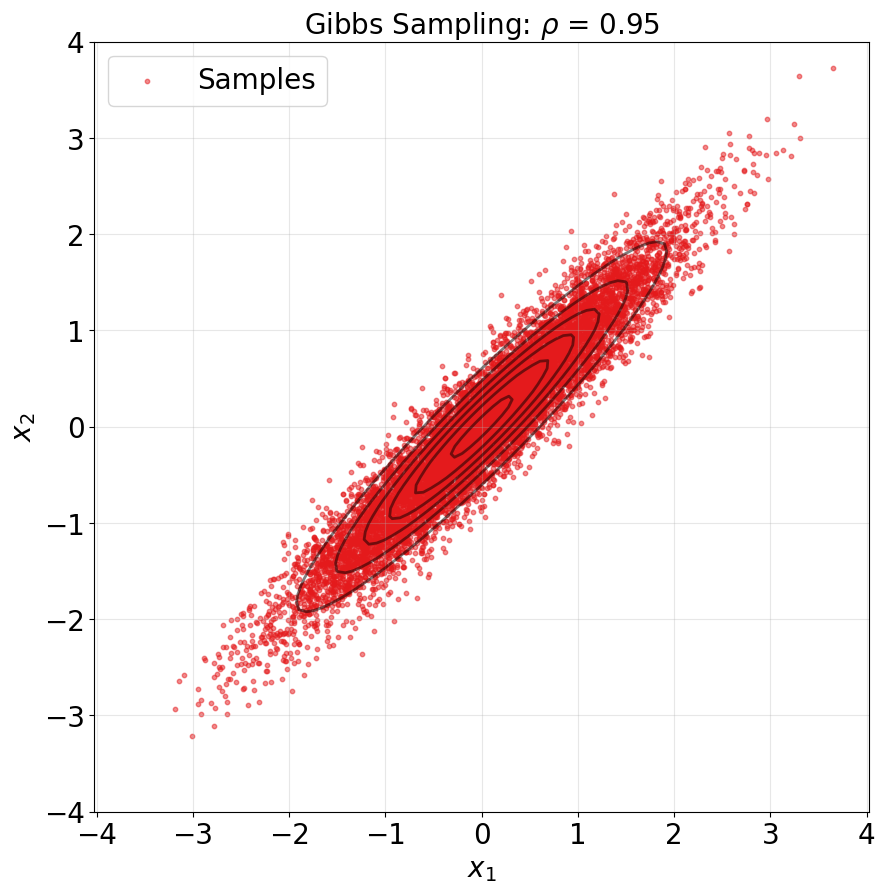

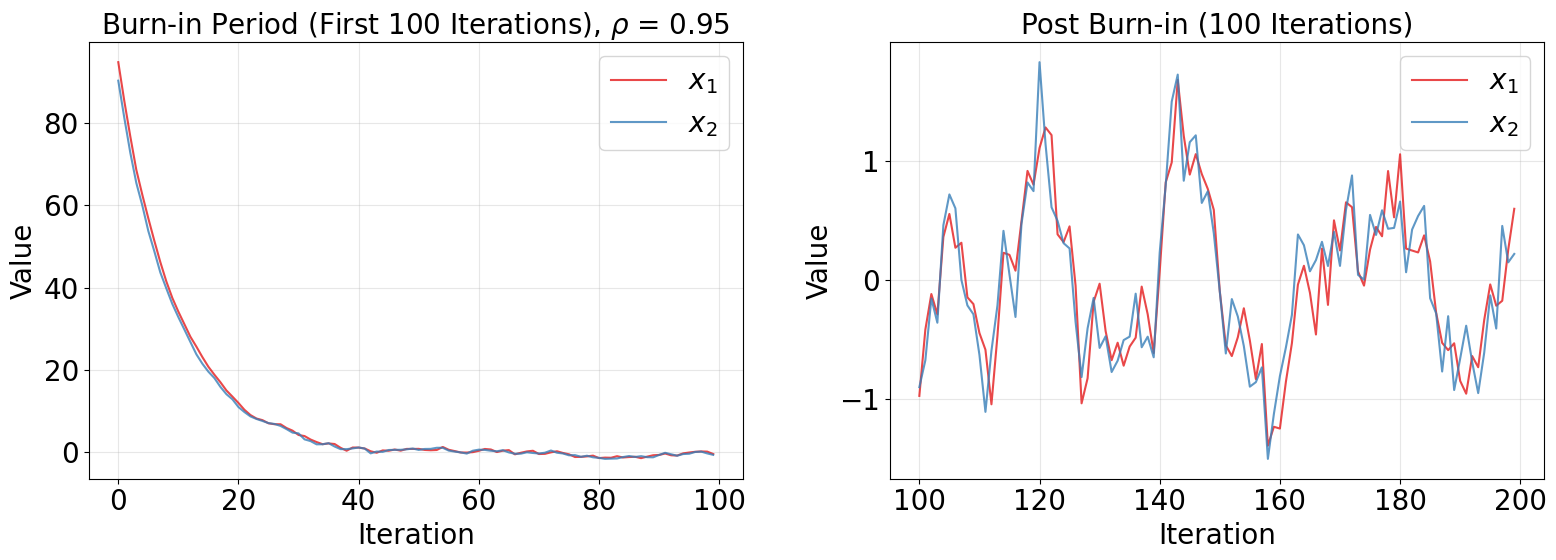

In [19]:
# Run Gibbs sampling with high correlation
n_samples = 10000
rho = 0.95
samples_high_corr = gibbs_sampler(n_samples, rho)

# Visualize the samples and burn-in period
plot_samples(samples_high_corr, rho, n_burn=100, n_thin=1)
plot_chains(samples_high_corr, rho, n_burn=100)

### Low Correlation Case (ρ = 0.1)

The dramatic difference in sampling behavior with low correlation illustrates why understanding parameter correlations is crucial for efficient MCMC:

**Efficient Exploration of Parameter Space**

With $\rho = 0.1$, the joint distribution is nearly circular rather than elongated. The coordinate-wise updates of Gibbs sampling are now well-aligned with the natural geometry of the distribution. Each update can make substantial progress in exploring new regions, rather than being confined to small steps along a correlation ridge.

**Rapid Mixing and Convergence**

The chain traces show much more rapid fluctuations between positive and negative values. Key observations:
- The burn-in period is barely visible—the chain quickly "forgets" its extreme starting position
- Both variables explore their full range within just a few iterations
- The larger conditional variance $(1 - 0.1^2 \approx 0.99)$ allows for substantial moves

**Independent-Like Behavior**

Although Gibbs sampling always produces correlated samples (by construction), the low correlation between parameters means that knowing $x_1$ provides little information about $x_2$. This near-independence allows the sampler to efficiently explore the joint distribution, approaching the performance of independent sampling.


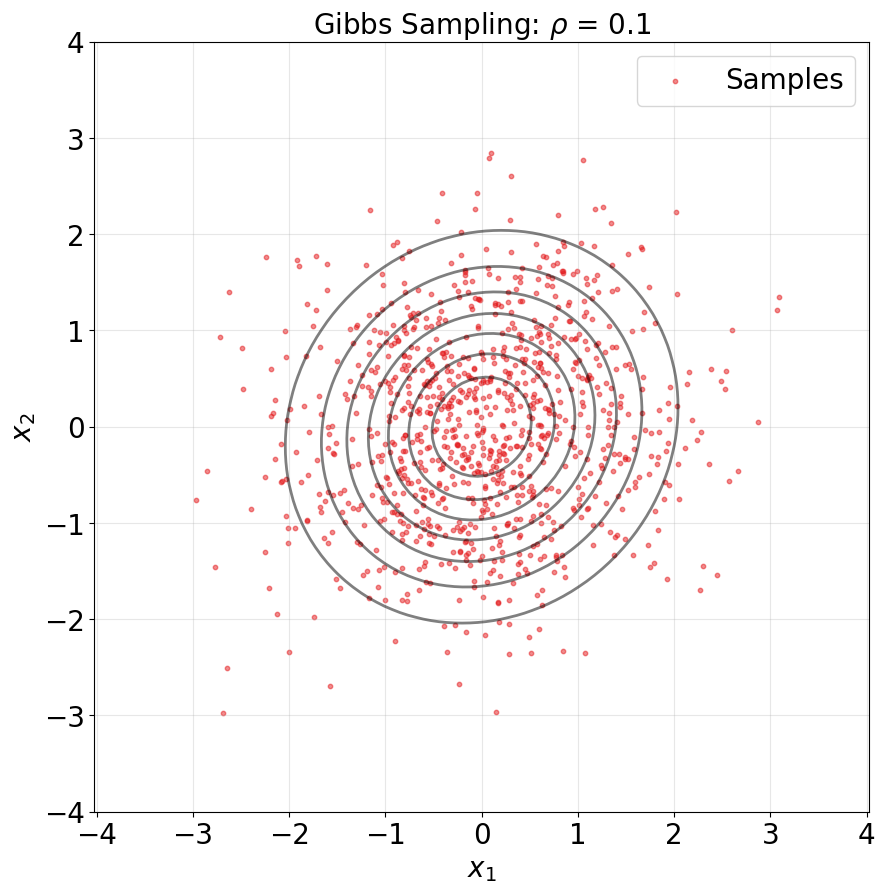

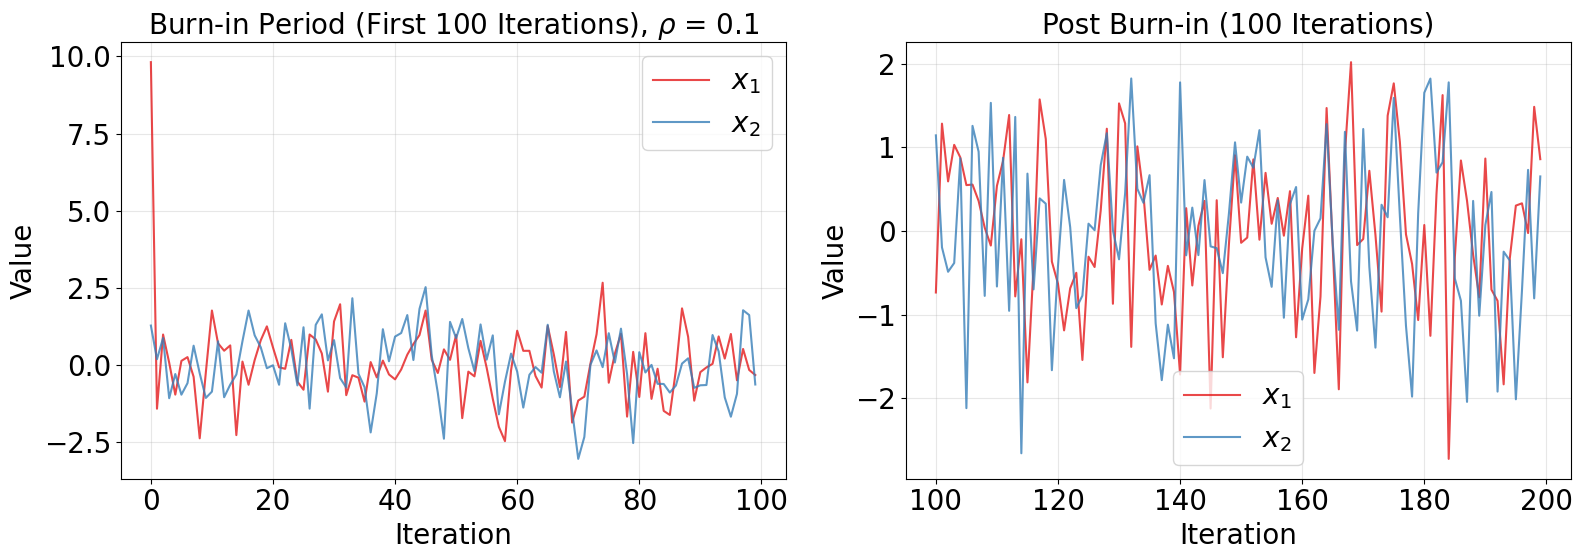

In [20]:
# Run Gibbs sampling with low correlation
n_samples = 10000
rho = 0.1
samples_low_corr = gibbs_sampler(n_samples, rho)

# Visualize the samples and burn-in period
plot_samples(samples_low_corr, rho, n_burn=100, n_thin=10)
plot_chains(samples_low_corr, rho, n_burn=100)

### Autocorrelation Analysis: Quantifying Sampling Efficiency

The autocorrelation plots provide quantitative confirmation of the visual patterns we observed:

**High Correlation Case (ρ = 0.95)**

The autocorrelation functions reveal severe inefficiency:
- Autocorrelation remains significant even at lag 100, indicating that samples separated by 100 iterations still share substantial information
- The slow, oscillatory decay reflects the zigzag path the sampler must take along the correlation ridge
- The effective sample sizes are dramatically reduced—despite generating 10,000 samples, we obtain equivalent information to far fewer independent samples

This inefficiency is intrinsic to Gibbs sampling with correlated parameters when updating one variable at a time. The solution is **block sampling**—updating correlated parameters jointly rather than individually. By sampling from $p(x_1, x_2 | \text{other parameters})$ instead of the individual conditionals, we can move efficiently along the correlation structure.

**Low Correlation Case (ρ = 0.1)**

The contrast is striking:
- Autocorrelation drops rapidly, approaching zero within 10-20 lags
- The clean exponential decay indicates efficient mixing
- The effective sample sizes are much higher, confirming that we're extracting near-maximal information from our samples

These results demonstrate why understanding parameter correlations is crucial for choosing an appropriate sampling strategy. In astronomical applications where strong correlations arise from physical relationships—such as the age-metallicity degeneracy in stellar populations or the correlation between dark matter halo mass and concentration—block Gibbs sampling as discussed in the textbook or alternative algorithms like Hamiltonian Monte Carlo may be necessary for efficient inference.

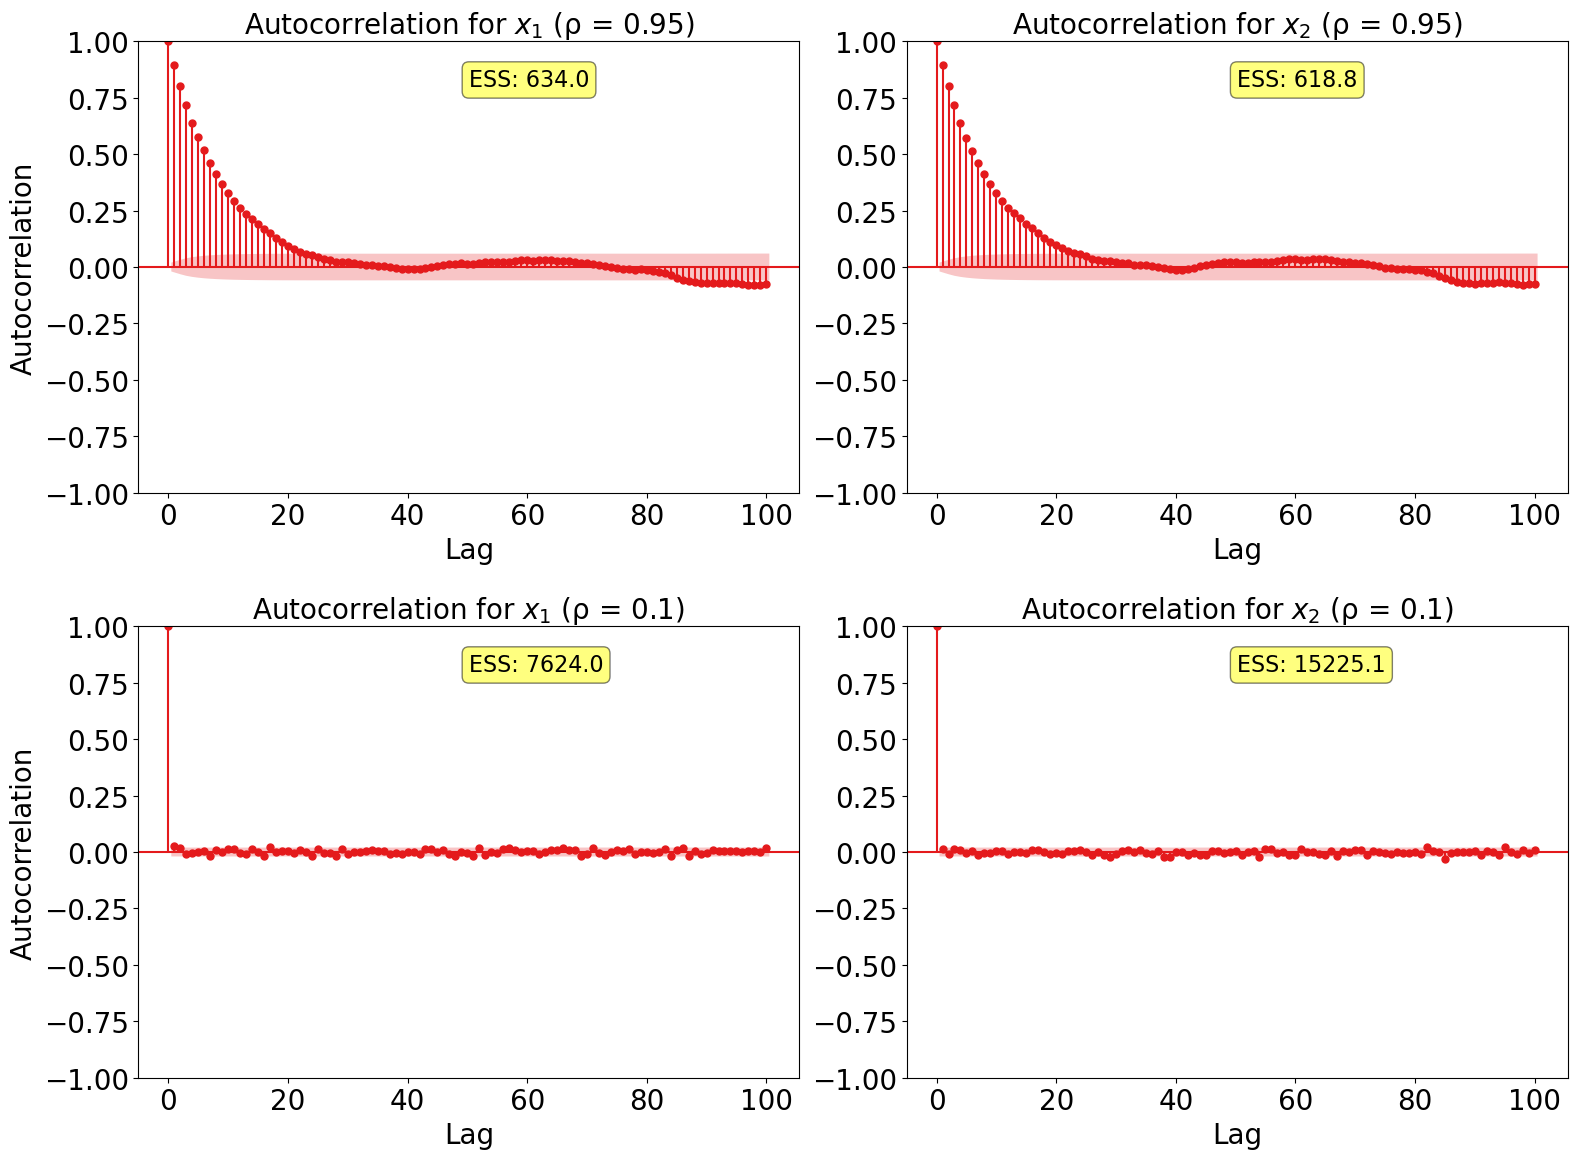

In [21]:
# Extract the samples for x1 and x2 variables from both chains
x1_high_corr = samples_high_corr[100:, 0]  # After burn-in
x2_high_corr = samples_high_corr[100:, 1]

x1_low_corr = samples_low_corr[100:, 0]  # After burn-in
x2_low_corr = samples_low_corr[100:, 1]

# Set up figure for autocorrelation plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# High correlation: autocorrelation for x1
sm.graphics.tsa.plot_acf(x1_high_corr, lags=100, ax=axes[0, 0])
axes[0, 0].set_title("Autocorrelation for $x_1$ (ρ = 0.95)")
axes[0, 0].set_xlabel("Lag")
axes[0, 0].set_ylabel("Autocorrelation")

# High correlation: autocorrelation for x2
sm.graphics.tsa.plot_acf(x2_high_corr, lags=100, ax=axes[0, 1])
axes[0, 1].set_title("Autocorrelation for $x_2$ (ρ = 0.95)")
axes[0, 1].set_xlabel("Lag")

# Low correlation: autocorrelation for x1
sm.graphics.tsa.plot_acf(x1_low_corr, lags=100, ax=axes[1, 0])
axes[1, 0].set_title("Autocorrelation for $x_1$ (ρ = 0.1)")
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation")

# Low correlation: autocorrelation for x2
sm.graphics.tsa.plot_acf(x2_low_corr, lags=100, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation for $x_2$ (ρ = 0.1)")
axes[1, 1].set_xlabel("Lag")

# Calculate and display ESS for each variable
ess_x1_high = calculate_ess(x1_high_corr)
ess_x2_high = calculate_ess(x2_high_corr)
ess_x1_low = calculate_ess(x1_low_corr)
ess_x2_low = calculate_ess(x2_low_corr)

axes[0, 0].text(0.5, 0.9, f"ESS: {ess_x1_high:.1f}", transform=axes[0, 0].transAxes,
                fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
axes[0, 1].text(0.5, 0.9, f"ESS: {ess_x2_high:.1f}", transform=axes[0, 1].transAxes,
                fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
axes[1, 0].text(0.5, 0.9, f"ESS: {ess_x1_low:.1f}", transform=axes[1, 0].transAxes,
                fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
axes[1, 1].text(0.5, 0.9, f"ESS: {ess_x2_low:.1f}", transform=axes[1, 1].transAxes,
                fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

plt.tight_layout()
plt.show()

## Summary

This tutorial has explored two fundamental MCMC techniques—the Metropolis-Hastings algorithm and Gibbs sampling—that have revolutionized statistical inference in astronomy. Through carefully chosen examples, we've developed both theoretical understanding and practical intuition for these powerful methods.

**The Metropolis-Hastings algorithm** demonstrated remarkable versatility, sampling from arbitrary distributions using only the ability to evaluate probability ratios. Our exploration revealed how proposal width critically affects performance: too narrow leads to inefficient random walks, too wide causes excessive rejections. The sweet spot balances exploration with acceptance, typically achieving 20-50% acceptance rates. Diagnostic tools—acceptance rates, autocorrelation functions, and convergence tests—proved essential for assessing chain quality.

**Gibbs sampling** showcased both the power and limitations of exploiting conditional structure. While it guarantees acceptance by sampling from exact conditionals, our bivariate Gaussian example revealed a crucial weakness: strongly correlated parameters lead to inefficient exploration despite perfect acceptance rates. The dramatic difference between high and low correlation cases illustrates why understanding parameter structure is essential before choosing a sampling strategy.

Both methods share common challenges that require careful attention:
- **Burn-in**: Initial samples must be discarded until chains reach their stationary distribution
- **Autocorrelation**: Successive samples are correlated, reducing the effective sample size
- **Convergence assessment**: Multiple diagnostics should confirm that chains have converged

The techniques mastered here provide the foundation for tackling complex astronomical inference problems. When parameters exhibit strong correlations—ubiquitous in astronomical models—consider block sampling, reparameterization, or modern algorithms like Hamiltonian Monte Carlo. The journey from simple random walks to sophisticated statistical inference exemplifies how computational methods continue to expand the frontiers of astronomical discovery.
